# GxB2 Servant Training Simulator

### Config

In [1]:
# Set your servants' level (LV) and ulticore level (UC).
MAIN_LV = 180
MAIN_UC = 40

SUB_LV = 160
SUB_UC = 0

# Set the number of attempts.
MAIN_HITS = 2  # E.g. change this to 4 if you buy 2 times daily.
SUB_HITS = 1  # E.g. change this to 2 if you have one hit left and want to simulate the next day.

### Damage ranges

In [2]:
# Import our friends.
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import fftconvolve
from scipy.special import binom, factorial
from scipy.interpolate import interp1d
from scipy.integrate import quad


# Full auras by default.
# Divided by 1000 to prevent precision errors.
def dmg(_lv, _uc):
    _au = 30 + 5 * (_uc // 25)
    _d = 5 * _lv + 20 * _uc + 8 * _au
    return np.array([1, 0.8, 1.2]) * _d / 1e3


MAIN_D = dmg(MAIN_LV, MAIN_UC)
SUB_D = dmg(SUB_LV, SUB_UC)
ALL_D = MAIN_HITS * MAIN_D + SUB_HITS * SUB_D
ALL_D_INT = (ALL_D * 1000).astype(int)

print("MAIN_DMG =", *(MAIN_D * 1000).astype(int))
print("SUB_DMG =", *(SUB_D * 1000).astype(int))
print("ALL_DMG =", *ALL_D_INT)

MAIN_DMG = 1980 1584 2376
SUB_DMG = 1040 832 1248
ALL_DMG = 5000 4000 6000


### Distributions
See [Irwin–Hall distribution](https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution) for details.
$${\displaystyle f_{X}(x;n)={\frac {1}{2(n-1)!}}\sum _{k=0}^{n}(-1)^{k}{n \choose k}(x-k)^{n-1}\operatorname {sgn}(x-k)}$$

In [3]:
def uniform_sum(_n):
    def _pdf(_x):
        _x = np.array(_x)
        _y = np.zeros(_x.shape)
        for _k in np.arange(_n + 1):
            _y += (-1)**_k * binom(_n,
                                   _k) * (_x - _k)**(_n - 1) * np.sign(_x - _k)
        return _y / 2 / factorial(_n - 1)

    return _pdf


def pdf(_n, _x, _a, _b):
    assert _n in range(1, 10), f"WTF is your {_n}?"
    _u = uniform_sum(_n)
    _x0 = (_x - _n * _a) / (_b - _a)
    return _u(_x0)


# The range need to be symmetrical about 0 to make fftconvolve work.
delta = 0.01
big_grid = np.arange(-ALL_D[2] - 1, ALL_D[2] + 1, delta)

PMF_MAIN = pdf(MAIN_HITS, big_grid, MAIN_D[1], MAIN_D[2])
PMF_SUB = pdf(SUB_HITS, big_grid, SUB_D[1], SUB_D[2])
PMF_SUM = fftconvolve(PMF_MAIN, PMF_SUB, 'same') * delta

PMF_MAIN = PMF_MAIN / sum(PMF_MAIN) / delta
PMF_SUB = PMF_SUB / sum(PMF_SUB) / delta
PMF_SUM = PMF_SUM / sum(PMF_SUM) / delta

I_MIN = np.where(big_grid >= ALL_D[1] - delta / 10)[0][0] - 10
I_MAX = np.where(big_grid <= ALL_D[2] + delta / 10)[-1][-1] + 10
pdf_all = interp1d(big_grid[I_MIN:I_MAX], PMF_SUM[I_MIN:I_MAX], kind='cubic')

### Plot

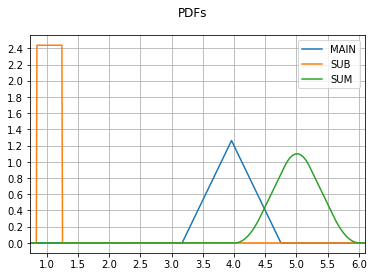

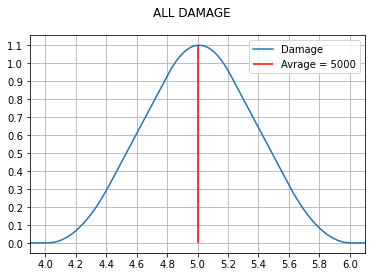

In [4]:
plt.plot(big_grid, PMF_MAIN, label='MAIN')
plt.plot(big_grid, PMF_SUB, label='SUB')
plt.plot(big_grid, PMF_SUM, label='SUM')
plt.axis(xmin=SUB_D[1] - 0.1, xmax=ALL_D[2] + 0.1)
plt.locator_params(nbins=16)
plt.legend(loc='best')
plt.suptitle('PDFs')
plt.grid()
plt.show()

plt.plot(big_grid, PMF_SUM, label='Damage')
plt.vlines(ALL_D[0],
           0,
           pdf_all(ALL_D[0]),
           label=f'Avrage = {ALL_D_INT[0]}',
           color='red')
plt.axis(xmin=ALL_D[1] - 0.1, xmax=ALL_D[2] + 0.1)
plt.locator_params(nbins=16)
plt.legend(loc='best')
plt.suptitle('ALL DAMAGE')
plt.grid()
plt.show()

### Probabilities

In [5]:
BOSSES = np.array([3600, 3800, 4000, 4500, 4800, 5500, 6000, 6500, 7000, 7500])


def fight(_hp):
    if _hp <= ALL_D_INT[1]:
        return 1
    if _hp > ALL_D_INT[2]:
        return 0
    return quad(pdf_all, _hp * 1e-3, ALL_D[2])[0]


print("BOSS_HP\tWIN_RATE")
for _boss in BOSSES:
    print(f"{_boss}\t" + "{p:6.2f}%".format(p=fight(_boss) * 100))

BOSS_HP	WIN_RATE
3600	100.00%
3800	100.00%
4000	100.00%
4500	 92.55%
4800	 71.88%
5500	  8.39%
6000	  0.00%
6500	  0.00%
7000	  0.00%
7500	  0.00%
